In [1]:
!pip install tensorflow

In [2]:
!pip install yfinance
!pip install scikit-learn
!pip install pandas
!pip install matplotlib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download stock data
# Choose a stock ticker symbol, 'AAPL' for Apple data.
ticker = 'AAPL'

# Download historical data from Yahoo Finance
data = yf.download(ticker, start='2010-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'))

# Focus on 'Close' prices for simplicity
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
training_data_len = int(np.ceil(len(scaled_data) * 80))
train_data = scaled_data[0:int(training_data_len), :]

In [7]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
model = Sequential()

In [11]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

In [12]:
# That was first Layer: LSTM layer

In [13]:
#Now, Second LSTM Layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

In [14]:
#Dense Layer
model.add(Dense(units=25))

In [15]:
#Output Layer (predicted price)
model.add(Dense(units=1))

In [16]:
#Compile the model using 'ADAM' optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3859/3859 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 0.0037


In [18]:
#Prepare data for 30-days forecast
last_60_days = scaled_data[-60:]
x_future = last_60_days.reshape((1,last_60_days.shape[0],1))

In [19]:
#Generate 30 days forecast
future_predictions = []
for _ in range(30):
  pred = model.predict(x_future)
  future_predictions.append(pred[0,0])

x_future = np.append(x_future[:,1:,:], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [20]:
# Transform predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [24]:
# Visualize the Results
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast = pd.DataFrame(future_predictions, index = forecast_dates, columns=['Prediction'])

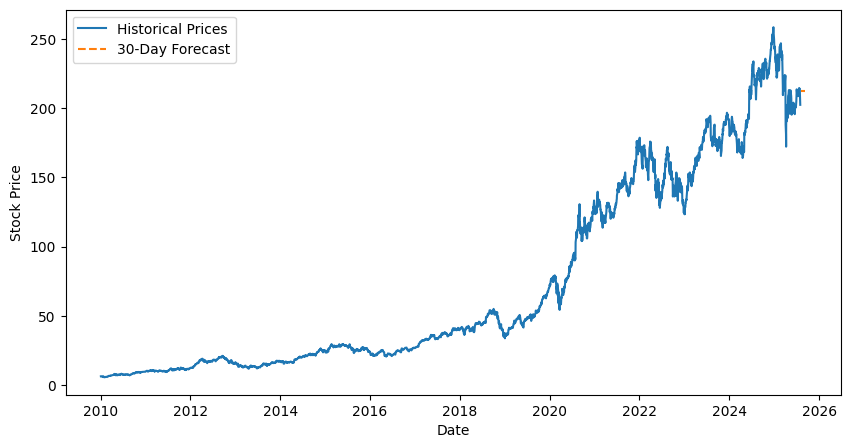

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(forecast, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()